In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Ganti path berikut sesuai lokasi dataset di Drive kamu
DATASET_DIR = '/content/drive/MyDrive/dataset_banana/'


Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 123

train_ds = image_dataset_from_directory(
    DATASET_DIR + 'train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)
val_ds = image_dataset_from_directory(
    DATASET_DIR + 'valid',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)
test_ds = image_dataset_from_directory(
    DATASET_DIR + 'test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

class_names = train_ds.class_names
print("Kelas:", class_names)


Found 11793 files belonging to 4 classes.
Found 1123 files belonging to 4 classes.
Found 562 files belonging to 4 classes.
Kelas: ['overripe', 'ripe', 'rotten', 'unripe']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

base_model = keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False  # tahap awal: freeze

preprocess_input = keras.applications.efficientnet.preprocess_input

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
earlystop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint("best_stage1.h5", save_best_only=True)

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=[earlystop, checkpoint]
)


Epoch 1/8
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8354 - loss: 0.4612

738/738 ━━━━━━━━━━━━━━━━━━━━ 4607s 600ms/step - accuracy: 0.8355 - loss: 0.4610 - val_accuracy: 0.9626 - val_loss: 0.1328
Epoch 2/8
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9480 - loss: 0.1522

738/738 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.9480 - loss: 0.1522 - val_accuracy: 0.9599 - val_loss: 0.1212
Epoch 3/8
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9563 - loss: 0.1271

738/738 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.9563 - loss: 0.1271 - val_accuracy: 0.9751 - val_loss: 0.0933
Epoch 4/8
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9550 - loss: 0.1267

738/738 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.9550 - loss: 0.1266 - val_accuracy: 0.9751 - val_loss: 0.0834
Epoch 5/8
737/738 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9618 - loss: 0.1106

738/738 ━━━━━━━━━━━━━━━━━━━━ 47s 53ms/step - accuracy: 0.9618 - loss: 0.1106 - val_accuracy: 0.9760 - val_loss: 0.0816
Epoch 6/8
738/738 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - accuracy: 0.9611 - loss: 0.1080 - val_accuracy: 0.9733 - val_loss: 0.0846
Epoch 7/8
738/738 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.9657 - loss: 0.1066 - val_accuracy: 0.9795 - val_loss: 0.0874
Epoch 8/8
737/738 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9589 - loss: 0.1119

738/738 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.9589 - loss: 0.1119 - val_accuracy: 0.9768 - val_loss: 0.0814


In [ ]:
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint2 = keras.callbacks.ModelCheckpoint("best_finetuned.h5", save_best_only=True)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    callbacks=[earlystop, checkpoint2]
)

model.save("/content/drive/MyDrive/efficientnet_banana_maturity.h5")


Epoch 1/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8822 - loss: 0.3534

738/738 ━━━━━━━━━━━━━━━━━━━━ 71s 71ms/step - accuracy: 0.8823 - loss: 0.3533 - val_accuracy: 0.9768 - val_loss: 0.0774
Epoch 2/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9409 - loss: 0.1661

738/738 ━━━━━━━━━━━━━━━━━━━━ 49s 67ms/step - accuracy: 0.9409 - loss: 0.1661 - val_accuracy: 0.9813 - val_loss: 0.0683
Epoch 3/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9571 - loss: 0.1210

738/738 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.9571 - loss: 0.1210 - val_accuracy: 0.9822 - val_loss: 0.0637
Epoch 4/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9656 - loss: 0.1047

738/738 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.9656 - loss: 0.1047 - val_accuracy: 0.9813 - val_loss: 0.0590
Epoch 5/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9681 - loss: 0.0961

738/738 ━━━━━━━━━━━━━━━━━━━━ 49s 67ms/step - accuracy: 0.9681 - loss: 0.0961 - val_accuracy: 0.9831 - val_loss: 0.0564
Epoch 6/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9676 - loss: 0.0906

738/738 ━━━━━━━━━━━━━━━━━━━━ 49s 67ms/step - accuracy: 0.9676 - loss: 0.0906 - val_accuracy: 0.9866 - val_loss: 0.0540
Epoch 7/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9777 - loss: 0.0681

738/738 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - accuracy: 0.9777 - loss: 0.0681 - val_accuracy: 0.9858 - val_loss: 0.0506
Epoch 8/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9802 - loss: 0.0548

738/738 ━━━━━━━━━━━━━━━━━━━━ 49s 67ms/step - accuracy: 0.9802 - loss: 0.0548 - val_accuracy: 0.9849 - val_loss: 0.0505
Epoch 9/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9796 - loss: 0.0559

738/738 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.9796 - loss: 0.0559 - val_accuracy: 0.9866 - val_loss: 0.0496
Epoch 10/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9801 - loss: 0.0528

738/738 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.9801 - loss: 0.0528 - val_accuracy: 0.9858 - val_loss: 0.0484
Epoch 11/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9863 - loss: 0.0418

738/738 ━━━━━━━━━━━━━━━━━━━━ 49s 67ms/step - accuracy: 0.9863 - loss: 0.0418 - val_accuracy: 0.9849 - val_loss: 0.0477
Epoch 12/12
738/738 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9881 - loss: 0.0373

738/738 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.9881 - loss: 0.0374 - val_accuracy: 0.9875 - val_loss: 0.0462


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━

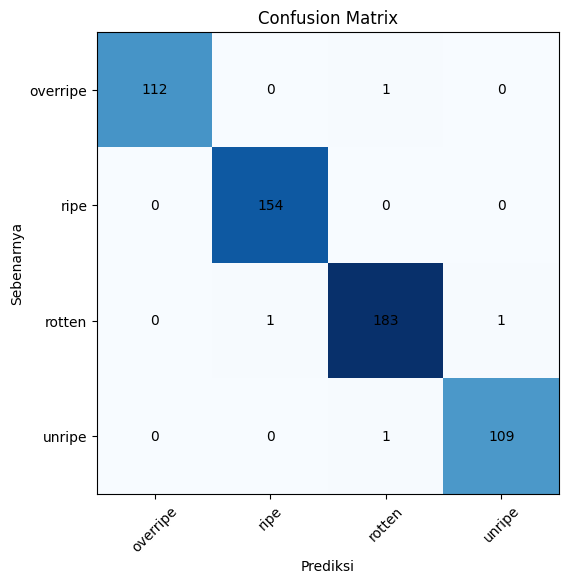

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import itertools

y_true, y_pred = [], []
for imgs, labels in test_ds:
    preds = model.predict(imgs)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Visualisasi Confusion Matrix
def plot_cm(cm, labels):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], ha='center', va='center')
    plt.xlabel('Prediksi')
    plt.ylabel('Sebenarnya')
    plt.show()

plot_cm(cm, class_names)


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = keras.applications.efficientnet.preprocess_input(img_arr)
    preds = model.predict(img_arr)
    idx = np.argmax(preds)
    print(f"Gambar: {os.path.basename(img_path)}")
    print(f"Prediksi: {class_names[idx]} (Probabilitas: {preds[0][idx]:.2f})")

# contoh
predict_image('/content/drive/MyDrive/dataset_banana/test/sample1.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
Gambar: sample1.jpg
Prediksi: ripe (Probabilitas: 0.53)


In [ ]:
model.save('/content/drive/MyDrive/efficientnet_banana_maturity.h5')
